In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image

In [8]:
!unzip /content/drive/MyDrive/CNNDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ml/seg_train/seg_train/mountain/7539.jpg  
  inflating: ml/seg_train/seg_train/mountain/7551.jpg  
  inflating: ml/seg_train/seg_train/mountain/7560.jpg  
  inflating: ml/seg_train/seg_train/mountain/7565.jpg  
  inflating: ml/seg_train/seg_train/mountain/7578.jpg  
  inflating: ml/seg_train/seg_train/mountain/7581.jpg  
  inflating: ml/seg_train/seg_train/mountain/7586.jpg  
  inflating: ml/seg_train/seg_train/mountain/7647.jpg  
  inflating: ml/seg_train/seg_train/mountain/7652.jpg  
  inflating: ml/seg_train/seg_train/mountain/7654.jpg  
  inflating: ml/seg_train/seg_train/mountain/7662.jpg  
  inflating: ml/seg_train/seg_train/mountain/767.jpg  
  inflating: ml/seg_train/seg_train/mountain/7672.jpg  
  inflating: ml/seg_train/seg_train/mountain/7679.jpg  
  inflating: ml/seg_train/seg_train/mountain/7681.jpg  
  inflating: ml/seg_train/seg_train/mountain/7693.jpg  
  inflating: ml/seg_train/seg_train/mountain/7695.jpg 

In [3]:
train_dir = '/content/ml/seg_train/seg_train'
test_dir = '/content/ml/seg_test/seg_test'
pred_dir = '/content/ml/seg_pred/seg_pred'

In [4]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# define load_dataset function to load dataset with labels
def load_dataset():

    datasets = [train_dir, test_dir]
    output = []

    for dataset in datasets:

        images1 = []
        labels1 = []
        print(f"loading {dataset}")

        for folder in os.listdir(dataset):

            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)

                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)

                images1.append(image_file)
                labels1.append(label)

        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')

        output.append((images1, labels1))
        print("Images file have been loaded")

    return output

In [11]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading /content/ml/seg_train/seg_train


100%|██████████| 2274/2274 [00:01<00:00, 2001.46it/s]


Images file have been loaded
loading /content/ml/seg_test/seg_test


100%|██████████| 510/510 [00:00<00:00, 1317.15it/s]


Images file have been loaded


In [12]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [13]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

In [14]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [15]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=42)

In [16]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=42)

In [17]:

train_images = train_images[:6000]
train_labels = train_labels[:6000]

In [18]:
test_images = test_images[:1400]
test_labels = test_labels[:1400]

In [19]:

trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [20]:

def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()
    ticks1= [key for key in class_labels.keys()]


    plt.figure(figsize=(15,6))

    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')

    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')

    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()

    return final_s

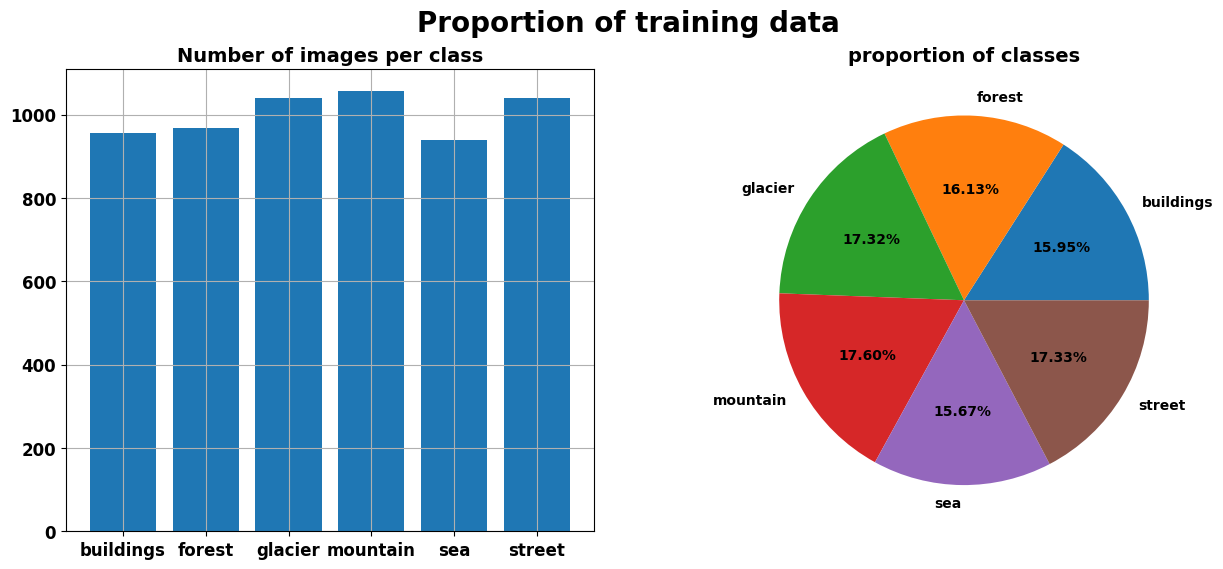

In [21]:
final_s = proportion_labels(train_labels, "training")

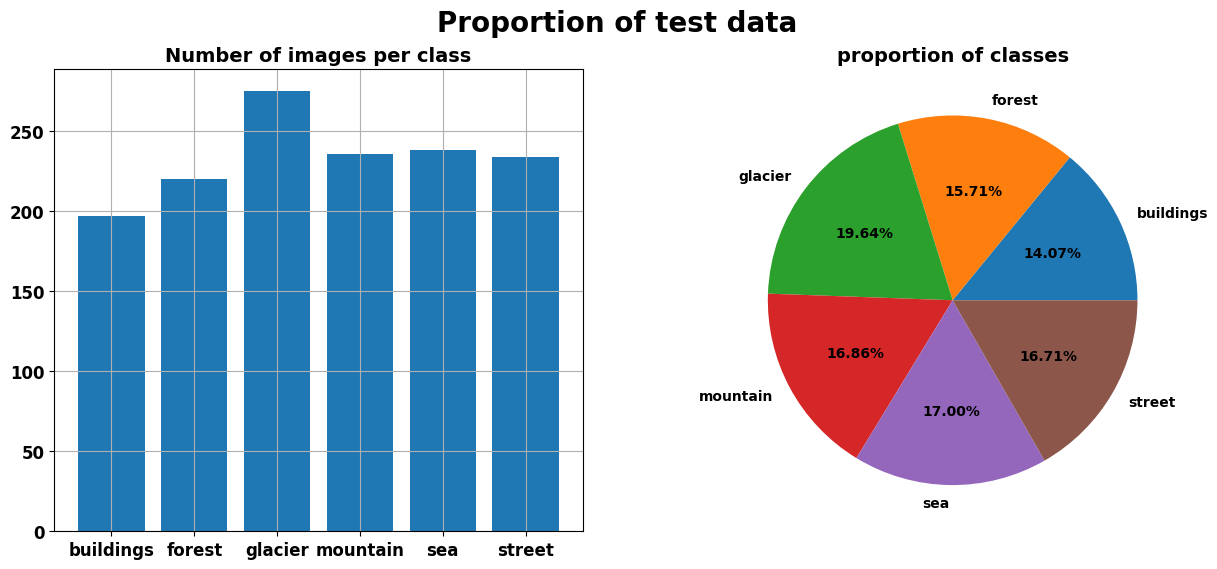

In [22]:
test_d = proportion_labels(test_labels, "test")

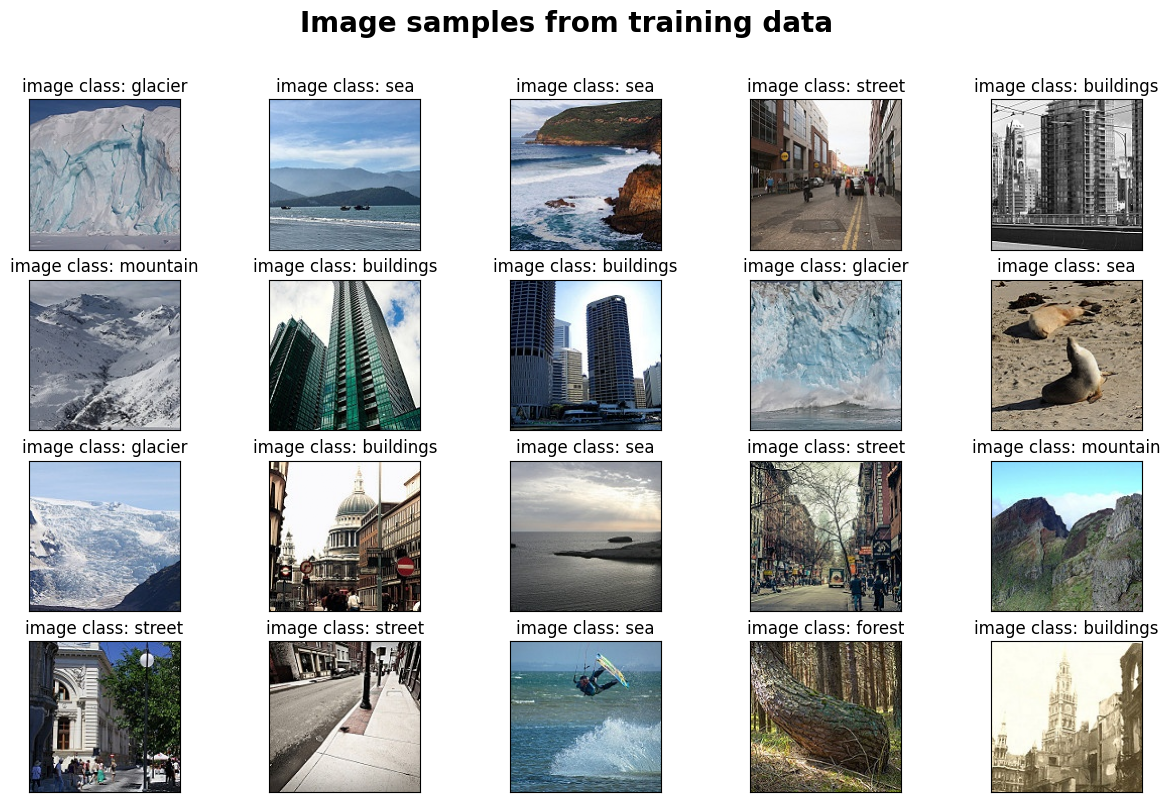

In [23]:

plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')

plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [24]:
#First keras model
model = models.Sequential()
model.add(layers.Conv2D(50, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(50, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(100, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(100, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(100, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 50)      1400      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 50)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 50)        22550     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 50)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 100)       45100     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 100)       0

In [25]:

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=25, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/25
47/47 [==============================] - 22s 279ms/step - loss: 1.4262 - accuracy: 0.4058 - val_loss: 1.2780 - val_accuracy: 0.4929
Epoch 2/25
47/47 [==============================] - 7s 140ms/step - loss: 1.1579 - accuracy: 0.5363 - val_loss: 1.1572 - val_accuracy: 0.5407
Epoch 3/25
47/47 [==============================] - 6s 130ms/step - loss: 1.0404 - accuracy: 0.5805 - val_loss: 1.0257 - val_accuracy: 0.5957
Epoch 4/25
47/47 [==============================] - 7s 148ms/step - loss: 0.9497 - accuracy: 0.6338 - val_loss: 0.9801 - val_accuracy: 0.6214
Epoch 5/25
47/47 [==============================] - 5s 112ms/step - loss: 0.8349 - accuracy: 0.6823 - val_loss: 1.0077 - val_accuracy: 0.6029
Epoch 6/25
47/47 [==============================] - 7s 143ms/step - loss: 0.7864 - accuracy: 0.7068 - val_loss: 0.8135 - val_accuracy: 0.6936
Epoch 7/25
47/47 [==============================] - 7s 145ms/step - loss: 0.7587 - accuracy: 0.7048 - val_loss: 0.7660 - val_accuracy: 0.7114
Epoch

In [26]:
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
len(images_paths)



7301

In [27]:
file_array = []

for file in images_paths[:9]:
    files = cv2.imread(file)/255.0
    file_array.append(files)

file_array = np.array(file_array)

In [28]:
# vector of prected probability of each class by our model
predictions = model.predict(file_array)
predictions.shape

1/1 [==============================] - 0s 485ms/step


(9, 6)

In [30]:
preds_index = np.argmax(predictions, axis=1)
preds_index

array([5, 2, 5, 0, 0, 1, 4, 4, 1])

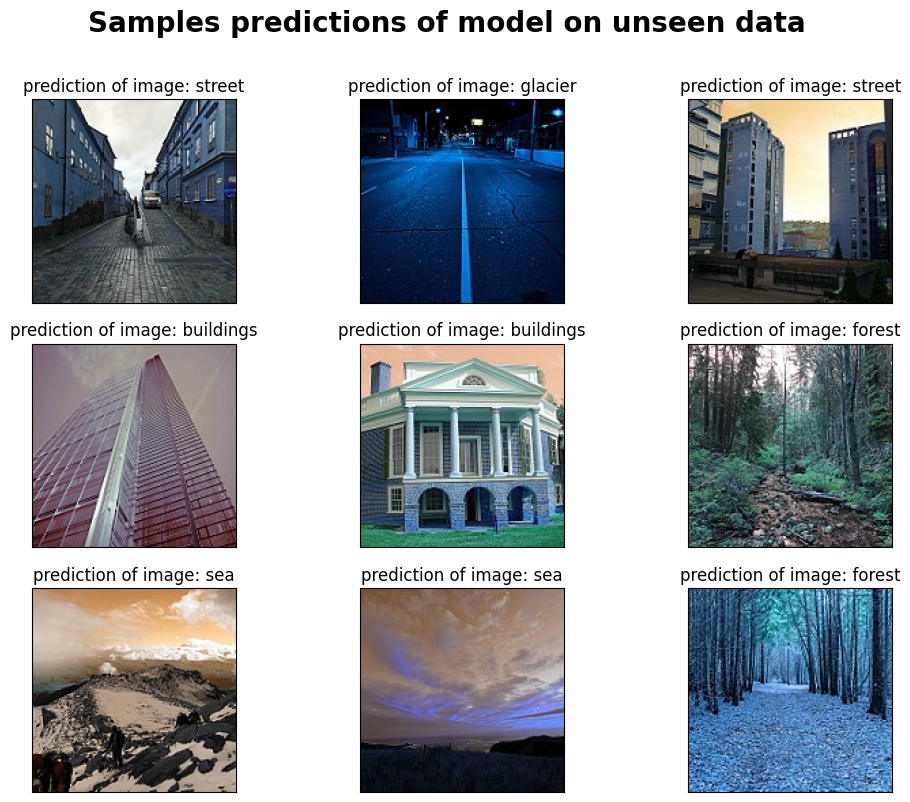

In [31]:
# sample prediciton on unseen data using model
plt.figure(figsize=(12,9))

for idx, i in enumerate(preds_index):
    plt.subplot(3,3, idx+1)
    plt.imshow(file_array[idx])
    plt.title(f"prediction of image: {class_names[i]}")
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')
plt.show()

In [32]:
def plot_loss_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1 ,len(acc) + 1)
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()

    plt.show()

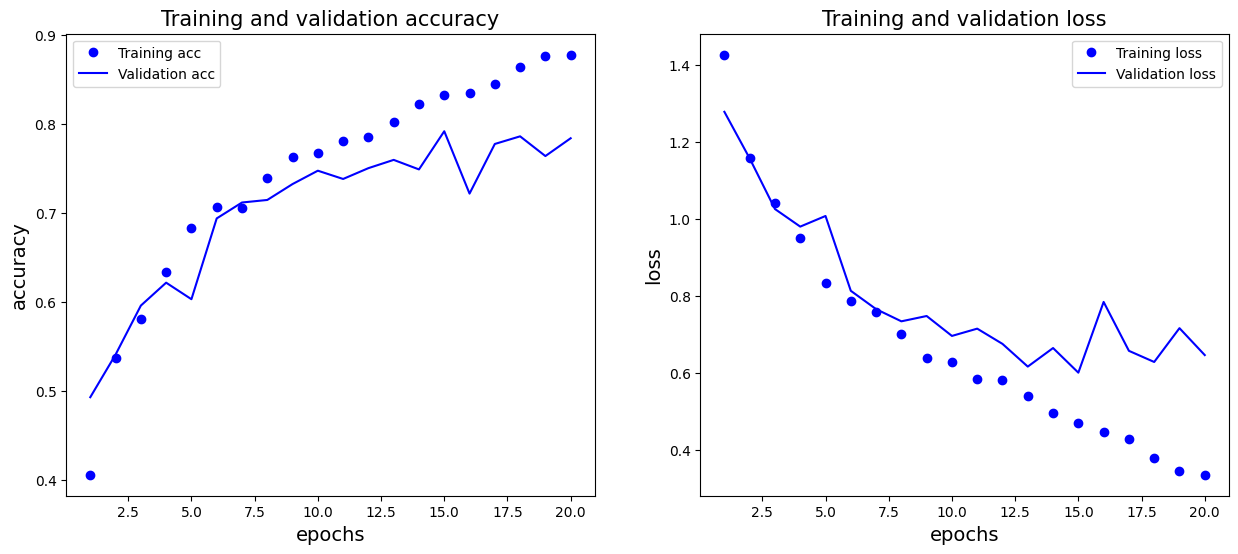

In [33]:
# call the function to plot the curves
plot_loss_accuracy(history)

In [34]:

preds = model.predict(tst_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

44/44 [==============================] - 1s 10ms/step
Shape of the prediction indexs (1400, 6)
Shape of predicitons vector: (1400,)


In [35]:

test_list = []
for i in test_labels:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (1400,)


In [36]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):

    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]

    print("Number of total mislabeled images", mislables_labels.shape)

    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')

        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()
    return mislables_labels

Number of total mislabeled images (303,)


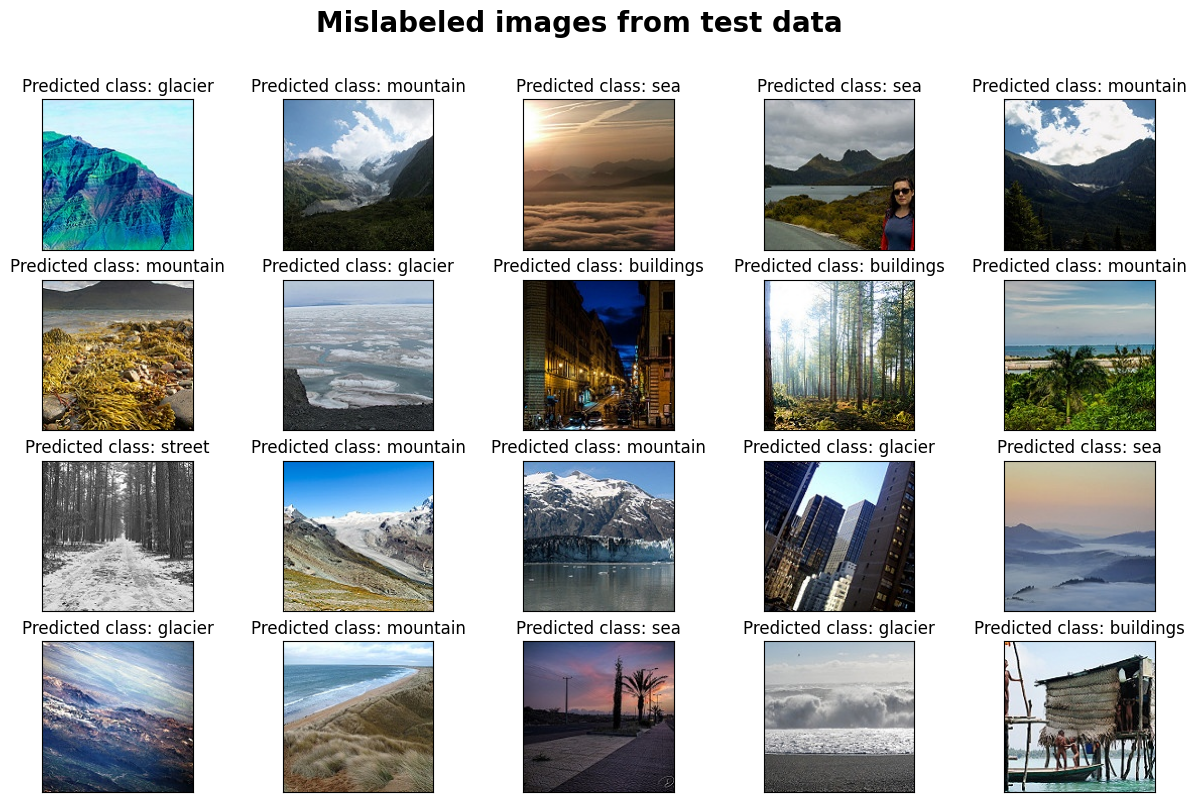

In [37]:
mislables_labels = mislabled_images(class_names, tst_images_norm, test_array, predictions_f)

In [ ]:
# model vgg16

conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# Extract training feature map from vgg16 conv_base
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm)

44/44 [==============================] - 6s 130ms/step


In [ ]:

train_featuremap.shape, test_featuremap.shape

((6000, 4, 4, 512), (1400, 4, 4, 512))

In [ ]:

model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(6, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2098950 (8.01 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [ ]:

result = model2.fit(train_featuremap, train_labels,
                   batch_size=128,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

Epoch 1/30
47/47 [==============================] - 4s 23ms/step - loss: 1.4324 - accuracy: 0.4377 - val_loss: 0.9979 - val_accuracy: 0.7600
Epoch 2/30
47/47 [==============================] - 1s 17ms/step - loss: 0.9332 - accuracy: 0.6867 - val_loss: 0.7167 - val_accuracy: 0.8029
Epoch 3/30
47/47 [==============================] - 1s 17ms/step - loss: 0.7239 - accuracy: 0.7563 - val_loss: 0.5848 - val_accuracy: 0.8264
Epoch 4/30
47/47 [==============================] - 1s 16ms/step - loss: 0.6123 - accuracy: 0.7942 - val_loss: 0.5176 - val_accuracy: 0.8386
Epoch 5/30
47/47 [==============================] - 1s 17ms/step - loss: 0.5481 - accuracy: 0.8048 - val_loss: 0.4777 - val_accuracy: 0.8429
Epoch 6/30
47/47 [==============================] - 1s 17ms/step - loss: 0.5032 - accuracy: 0.8227 - val_loss: 0.4505 - val_accuracy: 0.8521
Epoch 7/30
47/47 [==============================] - 1s 17ms/step - loss: 0.4807 - accuracy: 0.8302 - val_loss: 0.4300 - val_accuracy: 0.8529
Epoch 8/30
47

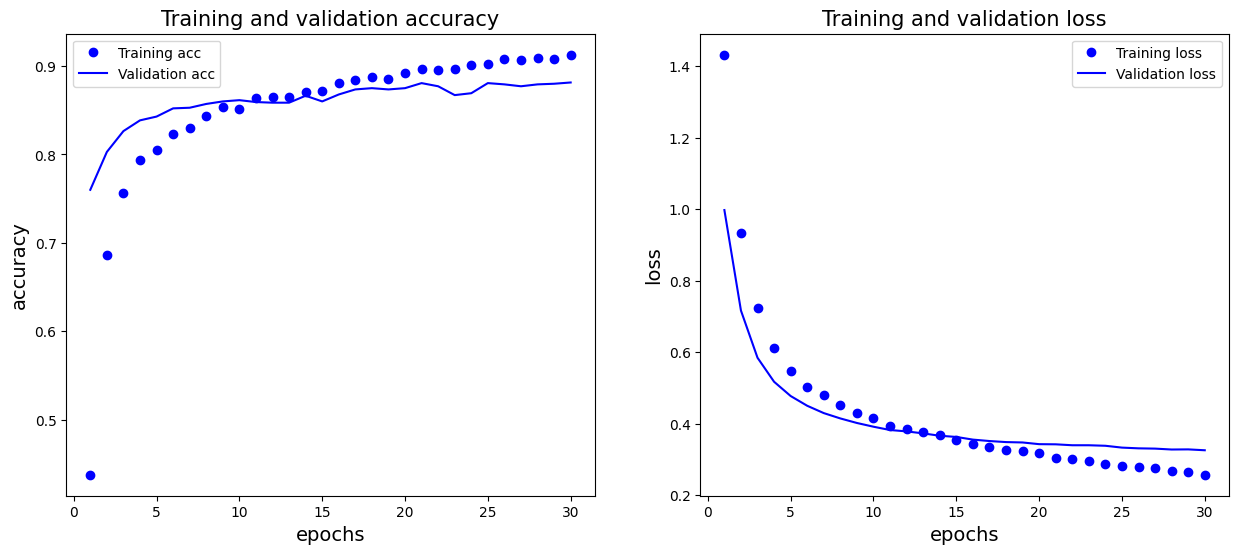

In [ ]:
# plotting loss and accuracy curves
plot_loss_accuracy(result)

In [ ]:

pred = model2.predict(test_featuremap)
predictions = np.argmax(pred, axis=1)
predictions.shape

44/44 [==============================] - 0s 3ms/step


(1400,)

Number of total mislabeled images (166,)


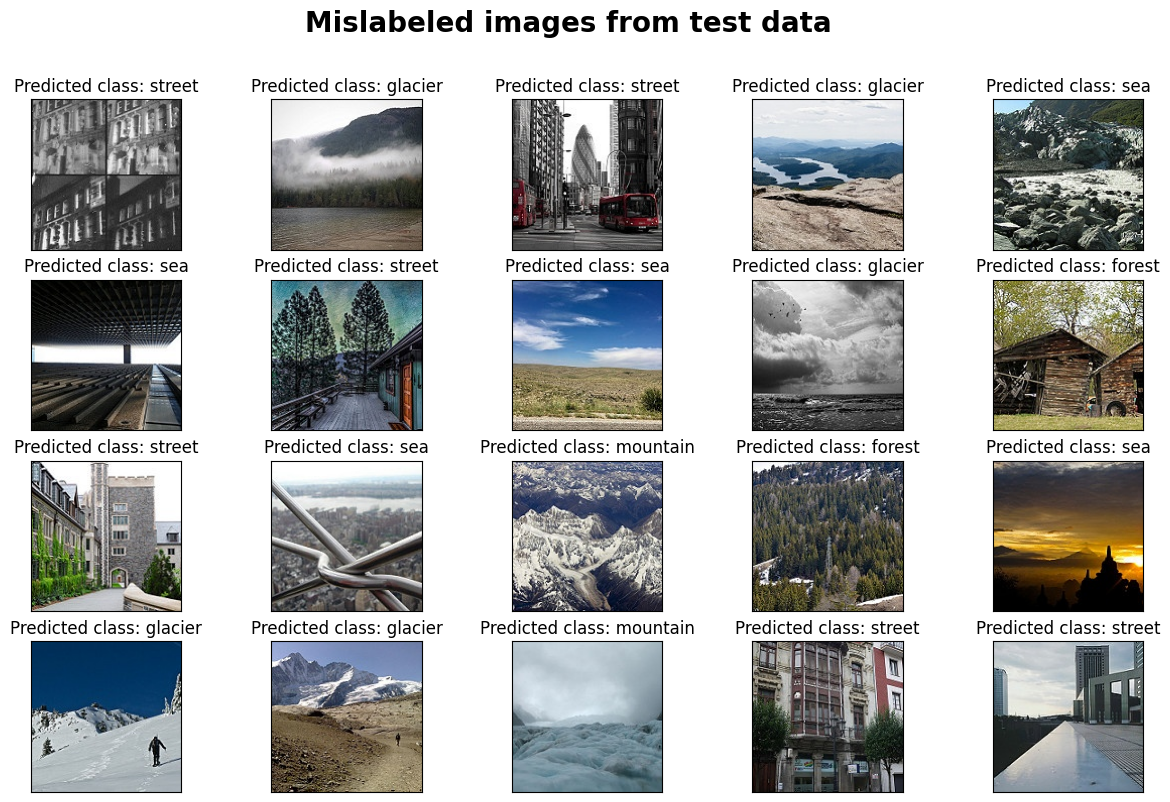

In [ ]:
mislables_labels= mislabled_images(class_names, tst_images_norm, test_array, predictions)

In [ ]:
def images_classifier(images_paths, class_names):
    file_array2 = []

    for file2 in images_paths:
        files2 = cv2.imread(file2)/255.0
        file_array2.append(files2)

    file_array2 = np.array(file_array2)

    img_arr = conv_base.predict(file_array2)


    img_pred = model2.predict(img_arr)
    img_predf = np.argmax(img_pred, axis=1)
    print("shape of the predicted array:", img_predf.shape)

    plt.figure(figsize=(17,13))

    for idx, i in enumerate(img_predf):
        plt.subplot(4,5, idx+1)
        plt.imshow(file_array2[idx])
        plt.title(f"prediction of image: {class_names[i]}")
        plt.xticks([])
        plt.yticks([])

    plt.suptitle("Samples predicition of model2 on unseen data", size=20, weight='bold')
    plt.show()

1/1 [==============================] - 0s 18ms/step
shape of the predicted array: (20,)


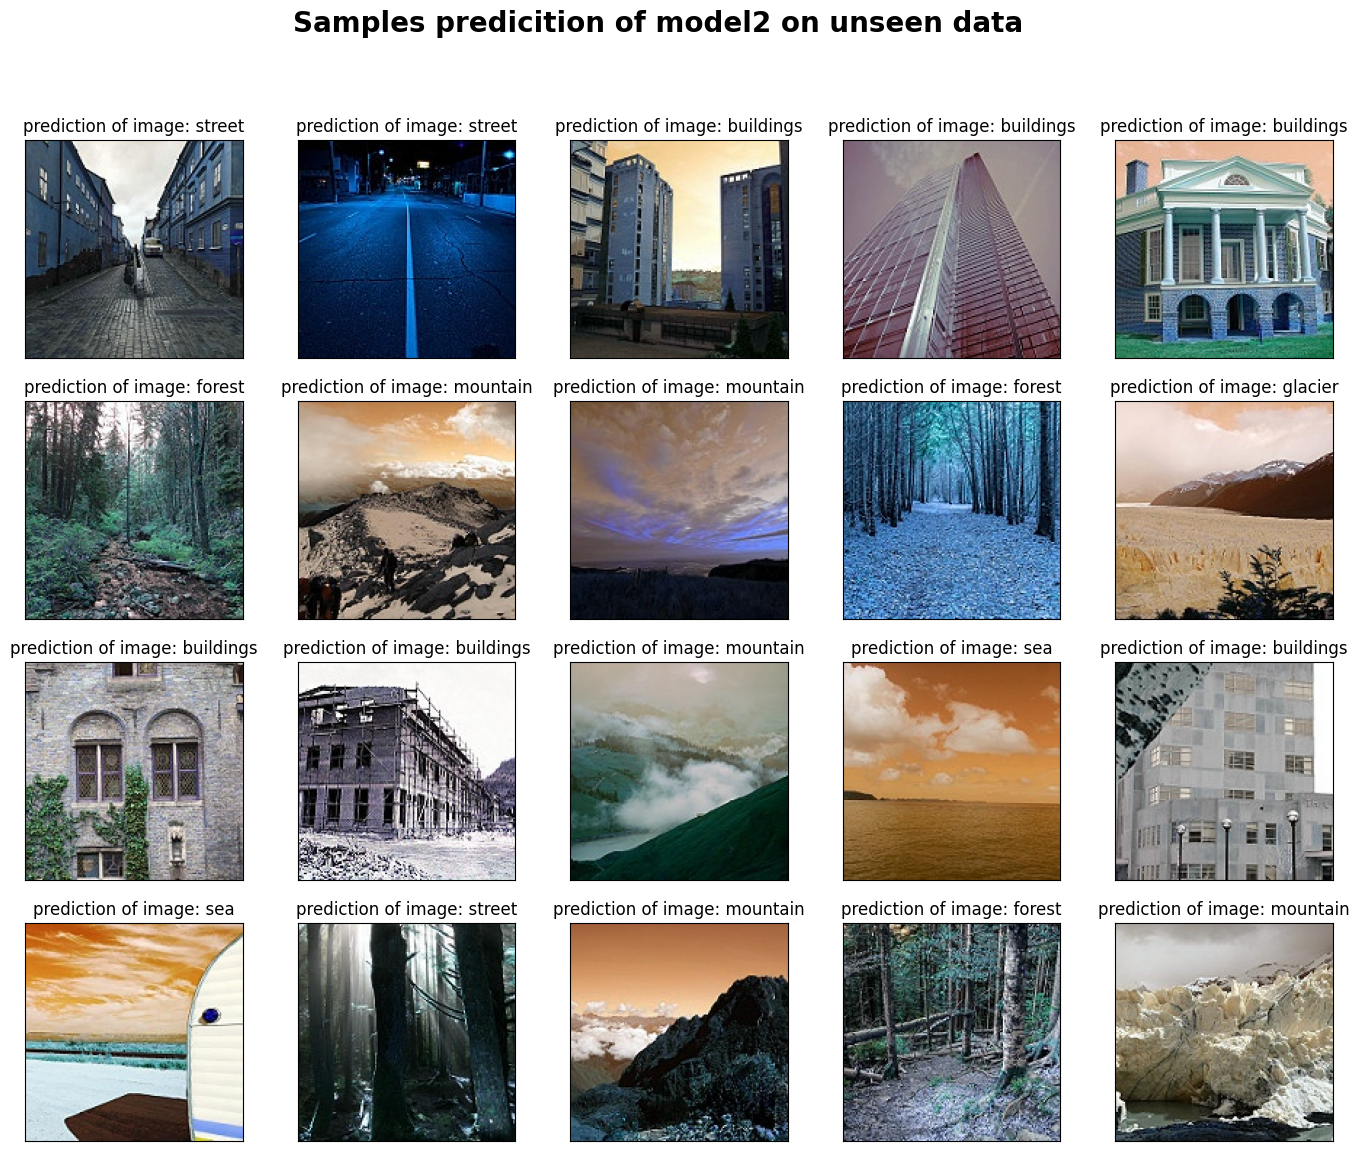

In [ ]:
images_classifier(images_paths[:20], class_names)